In [1]:

import numpy as np
import mdtraj as md
import nglview as nv
import matplotlib.pyplot as plt

import pyemma
import pickle
import torch
import lightning

from mlcolvar.cvs import BaseCV
from mlcolvar.core import FeedForward, Normalization
from mlcolvar.core.transform import Statistics, Transform
from matplotlib.colors import LogNorm

from tqdm import tqdm
from itertools import combinations

np.bool = np.bool_
CUDA_DEVICE = 7
blue = (70 / 255, 110 / 255, 250 / 255)

# Load

In [2]:
tae_path = "/home/shpark/prj-mlcv/lib/bioemu/model/tae-jit.pt"
mlcv_model = torch.jit.load(tae_path)
mlcv_model.eval()
print(mlcv_model)

RecursiveScriptModule(
  original_name=TAE
  (loss_fn): RecursiveScriptModule(original_name=MSELoss)
  (norm_in): RecursiveScriptModule(original_name=Normalization)
  (encoder): RecursiveScriptModule(
    original_name=FeedForward
    (nn): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=Tanh)
      (2): RecursiveScriptModule(original_name=Dropout)
      (3): RecursiveScriptModule(original_name=Linear)
      (4): RecursiveScriptModule(original_name=Tanh)
      (5): RecursiveScriptModule(original_name=Dropout)
      (6): RecursiveScriptModule(original_name=Linear)
      (7): RecursiveScriptModule(original_name=Dropout)
    )
  )
  (decoder): RecursiveScriptModule(
    original_name=FeedForward
    (nn): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=ReLU)
      (2): Recursi

In [3]:
# TICA Model

class TICA_WRAPPER():
	def __init__(
		self,
		tica_model_path,
		pdb_path,
	):
		super().__init__()
		with open(tica_model_path, 'rb') as f:
			tica_model = pickle.load(f)
		self.tica_model = tica_model
		self.pdb = md.load(pdb_path)
		self.ca_resid_pair = np.array(
			[(a.index, b.index) for a, b in combinations(list(self.pdb.topology.residues), 2)]
		)
  
		print(self.tica_model)

	def transform(
		self,
		cad_data: np.ndarray,
	):
		feature_distance_switch = (1 - np.power(cad_data / 0.8, 6)) / (1 - np.power(cad_data / 0.8, 12))
		tica_coord = self.tica_model.transform(feature_distance_switch)
		
		return tica_coord

	def pos2cad(
		self,
		pos_data: np.ndarray,
	):
		self.pdb.xyz = pos_data
		ca_pair_distances, _ = md.compute_contacts(
			self.pdb, scheme="ca", contacts=self.ca_resid_pair, periodic=False
		)
		return ca_pair_distances

tica_wrapper = TICA_WRAPPER(
	tica_model_path="/home/shpark/prj-mlcv/lib/DESRES/data/CLN025_tica_model_switch.pkl",
	pdb_path="/home/shpark/prj-mlcv/lib/DESRES/data/CLN025_desres.pdb",
)

TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=5,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


In [4]:
# Committor model

committor_path = "./committor.pt"
committor_model = torch.jit.load(committor_path, map_location=f"cuda:{CUDA_DEVICE}")
print(committor_model)

RecursiveScriptModule(
  original_name=NN_committor_guess
  (nn): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Tanh)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=Tanh)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=CustomActivation)
  )
)


In [5]:
# Alpha carbon distances
simulation_num = 0
pdb_path = "/home/shpark/prj-mlcv/lib/DESRES/data/CLN025_desres.pdb"
pos_path = "/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-all/pos.pt"
cad_path = "/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-all/cad.pt"

pos_torch = torch.load(pos_path)
cad_torch = torch.load(cad_path)

print(pos_torch.shape)
print(cad_torch.shape)

torch.Size([530000, 166, 3])
torch.Size([530000, 45])


# Analysis

In [8]:
cad_data = cad_torch.numpy()
cv = mlcv_model(torch.from_numpy(cad_data))
cv = cv.detach().cpu().numpy()

print(cv.shape)
print(cv.max(), cv.min())
MLCV_DIM = cv.shape[1]
cv = -cv

(530000, 1)
1.0 -1.0


## TICA and CVs

(530000, 2)


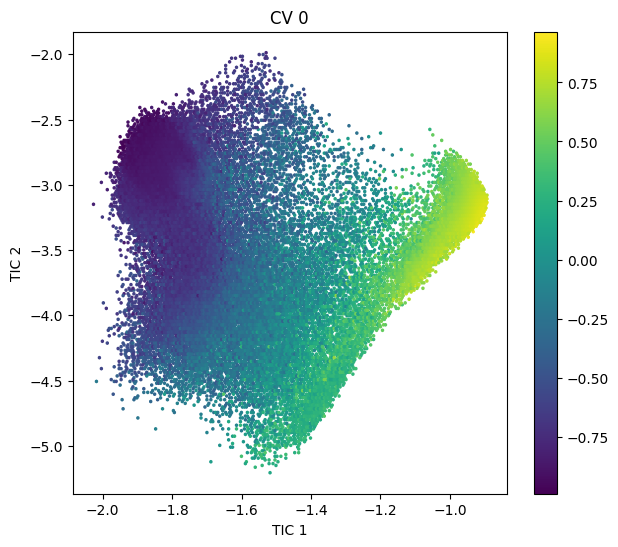

In [17]:
tica_data = tica_wrapper.transform(cad_data)
x = tica_data[:, 0]
y = tica_data[:, 1]
print(tica_data.shape)

# Plot
for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	hb = ax.hexbin(
		x, y, C=cv[:, cv_dim],
		gridsize=200,                     # controls resolution
		reduce_C_function=np.mean,       # compute average per hexagon
		cmap='viridis',                  # colormap
	)
	plt.colorbar(hb)
	plt.xlabel("TIC 1")
	plt.ylabel("TIC 2")
	plt.title(f"CV {cv_dim}")
	plt.show()

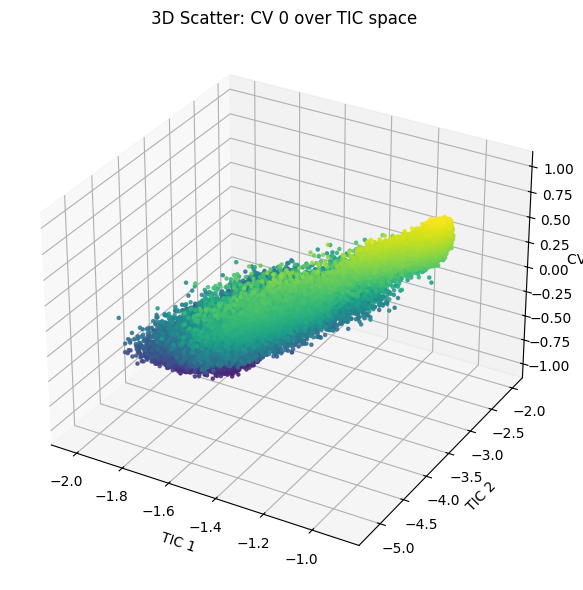

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plots
import numpy as np

tica_data = tica_wrapper.transform(cad_data)
x = tica_data[:, 0]
y = tica_data[:, 1]

for cv_dim in range(MLCV_DIM):
    z = cv[:, cv_dim]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=5, alpha=0.8)

    ax.set_xlabel('TIC 1')
    ax.set_ylabel('TIC 2')
    ax.set_zlabel(f'CV {cv_dim}')
    ax.set_title(f'3D Scatter: CV {cv_dim} over TIC space')

    # fig.colorbar(sc, ax=ax, label='CV Value')
    plt.tight_layout()
    # ax.view_init(elev=40, azim=50)
    plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

# TICA-transformed coordinates
tica_data = tica_wrapper.transform(cad_data)
x = tica_data[:, 0]
y = tica_data[:, 1]

# Loop over each CV dimension
for cv_dim in range(MLCV_DIM):
    z = cv[:, cv_dim]

    fig = go.Figure(
        data=go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=3,
                color=z,
                colorscale='Viridis',
                colorbar=dict(title=f'CV {cv_dim}'),
                opacity=0.8
            )
        )
    )

    fig.update_layout(
        scene=dict(
            xaxis_title='TIC 1',
            yaxis_title='TIC 2',
            zaxis_title=f'CV {cv_dim}',
			aspectmode='manual',
        	aspectratio=dict(x=1, y=1, z=1)
        ),
        title=f'CV {cv_dim} in TICA Space',
        margin=dict(l=0, r=0, b=0, t=30)
    )

    fig.show()

## Bond number and CVs

In [11]:
def foldedness_by_hbond(
    traj,
    distance_cutoff=0.35,
    bond_number_cutoff=3
):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	# TYR1N-YR10OT1
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int) 
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3


	# TYR1N-YR10OT2
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3


	# ASP3N-TYR8O
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6OG1-ASP3O
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6N-ASP3OD1
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff)).astype(int)
 
	# THR6N-ASP3OD2
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# GLY7N-ASP3O
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 

	# TYR10N-TYR1O
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff)).astype(int)

	# ASP3OD_THR6OG1_ASP3N_THR8O
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + label_ASP3N_TYR8O + label_THR6OG1_ASP3O \
		+ label_THR6N_ASP3OD1 + label_THR6N_ASP3OD2 + label_GLY7N_ASP3O + label_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff

	return labels, bond_sum

In [12]:
dummy_pdb = tica_wrapper.pdb
dummy_pdb.xyz = pos_torch.numpy()
label, bond_num = foldedness_by_hbond(dummy_pdb)

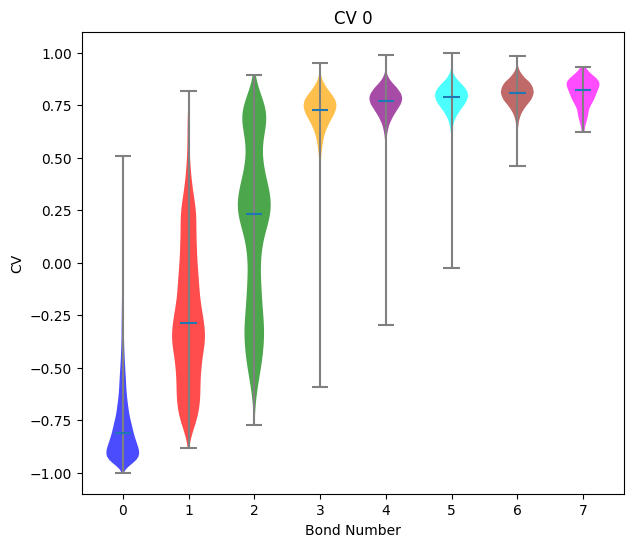

In [13]:
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'brown', 'magenta']

for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	x = cv[:, cv_dim]
	y = bond_num
	grouped = [x[y == i] for i in sorted(np.unique(y))]
	violin = plt.violinplot(grouped, positions=sorted(np.unique(y)), showmeans=False, showmedians=True)
	for i, body in enumerate(violin['bodies']):
		body.set_facecolor(colors[i % len(colors)])
		body.set_alpha(0.7)
  
	violin['cbars'].set_edgecolor('gray')
	violin['cmaxes'].set_edgecolor('gray')
	violin['cmins'].set_edgecolor('gray')
	
	ax.set_xlabel("Bond Number")
	ax.set_ylabel("CV")
	ax.set_title(f"CV {cv_dim}")
	plt.show()
 

## Committor and CVs

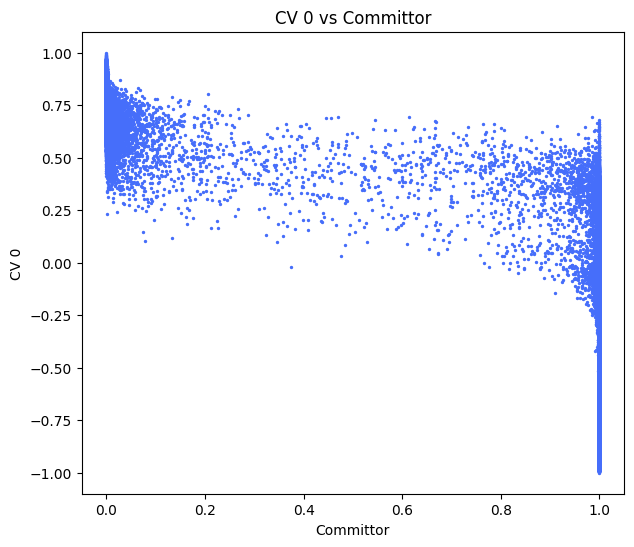

In [14]:
committor_value = committor_model(cad_torch.to(CUDA_DEVICE))
committor_value = committor_value.cpu().detach().numpy().flatten()


for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	ax.scatter(committor_value, cv[:, cv_dim], color=blue, s=2)
	ax.set_xlabel("Committor")
	ax.set_ylabel(f"CV {cv_dim}")
	ax.set_title(f"CV {cv_dim} vs Committor")
	plt.show()

# Conclusion